In [1]:
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras_facenet import FaceNet
import time


Fetching the LFW People Dataset:
The fetch_lfw_people function from sklearn.datasets is used to load the LFW (Labeled Faces in the Wild) dataset:

In [2]:
# Fetch the LFW people dataset
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

# Extract the images and labels
images = lfw_people.images
labels = lfw_people.target
target_names = lfw_people.target_names

print(f'Dataset contains {len(images)} images of {len(target_names)} different people.')


Dataset contains 942 images of 9 different people.


Initializing MediaPipe Face Detection :
MediaPipe's face detection solution is initialized for detecting faces in images:

In [3]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils


Preprocessing Images: 
A function to preprocess images, converting them to the required format and ensuring they are in RGB format:



In [4]:
def preprocess_image(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    if len(image.shape) == 2 or image.shape[2] == 1:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image
    return image_rgb


Detecting Faces using MediaPipe :
A function to detect faces in an image using MediaPipe's face detection model:

In [5]:
def detect_faces(image, min_detection_confidence=0.5):
    with mp_face_detection.FaceDetection(min_detection_confidence=min_detection_confidence) as face_detection:
        image_rgb = preprocess_image(image)
        image_uint8 = image_rgb.astype(np.uint8)
        results = face_detection.process(image_uint8)
        faces = []
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image_rgb.shape
                bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                       int(bboxC.width * iw), int(bboxC.height * ih)
                faces.append(bbox)
        return faces


Visualizing Detected Faces : A function to visualize detected faces by drawing bounding boxes around them:

In [6]:
def visualize_detected_faces(image, faces):
    example_image_bgr = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in faces:
        cv2.rectangle(example_image_bgr, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(example_image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


Initializing FaceNet Embedder : FaceNet model is initialized to extract facial embeddings:

In [7]:
embedder = FaceNet()

 Extracting FaceNet Embeddings:A function to extract embeddings for faces using the FaceNet model:

In [8]:
def extract_embeddings(image, bbox=None):
    if bbox is not None:
        x, y, w, h = bbox
        face = image[y:y+h, x:x+w]
        face_rgb = preprocess_image(face)
    else:
        face_rgb = preprocess_image(image)
    image_resized = cv2.resize(face_rgb, (160, 160))
    mean, std = image_resized.mean(), image_resized.std()
    if std == 0:  # Avoid division by zero
        std = 1
    image_normalized = (image_resized - mean) / std
    embeddings = embedder.embeddings([image_normalized])
    return embeddings[0]


Displaying Image Shape and Data Type
Printing the shape and data type of the first few images:

In [9]:
for i in range(5):
    image = images[i]
    preprocessed_image = preprocess_image(image)
    print(f"Image {i}: shape={preprocessed_image.shape}, dtype={preprocessed_image.dtype}")


Image 0: shape=(50, 37, 3), dtype=uint8
Image 1: shape=(50, 37, 3), dtype=uint8
Image 2: shape=(50, 37, 3), dtype=uint8
Image 3: shape=(50, 37, 3), dtype=uint8
Image 4: shape=(50, 37, 3), dtype=uint8


Detecting Faces in Sample Images
Detecting faces in a few sample images and visualizing them:

Image 0: Faces detected: [(-3, 5, 43, 43)]


c:\Users\garla\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


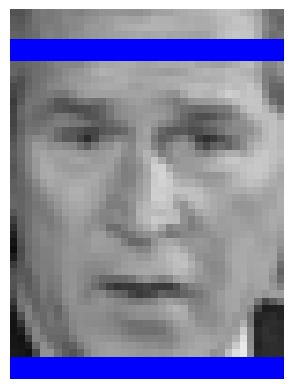

Image 1: Faces detected: [(-1, 5, 44, 44)]


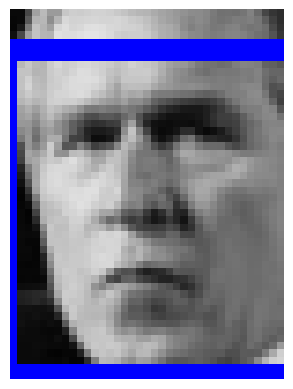

Image 2: Faces detected: [(-3, 6, 44, 44)]


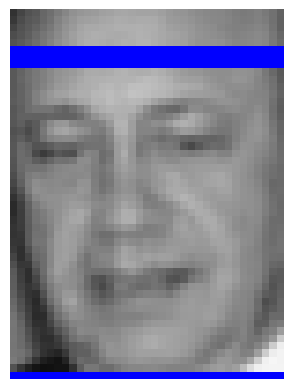

Image 3: Faces detected: [(-1, 7, 40, 40)]


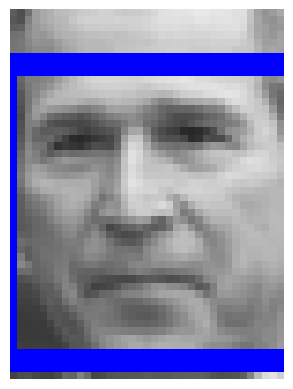

Image 4: Faces detected: [(-1, 6, 41, 41)]


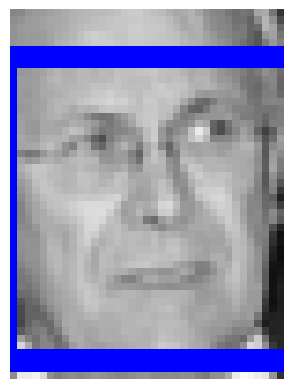

In [10]:
for i in range(5):
    image = images[i]
    faces = detect_faces(image)
    print(f"Image {i}: Faces detected: {faces}")
    visualize_detected_faces(image, faces)


Extracting Embeddings for All Images
Extracting embeddings for all images in the dataset:

In [11]:
start_time = time.time()
embeddings = np.array([extract_embeddings(image) for image in images])
end_time = time.time()
print(f"Time taken to extract embeddings: {end_time - start_time:.2f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

Checking Class Distribution
Checking for class imbalance in the dataset:

In [12]:
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

Class distribution: {0: 29, 1: 121, 2: 530, 3: 109, 4: 44, 5: 20, 6: 41, 7: 23, 8: 25}


Splitting Data into Training and Testing Sets
Splitting the data into training and testing sets:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42, stratify=labels)


Training a k-NN Classifier
Training a k-Nearest Neighbors (k-NN) classifier on the training data:

In [14]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

Predict and evaluate

In [15]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.56
Precision: 0.75
Recall: 0.56
F1-Score: 0.40


Example image for face detection

In [16]:
example_image = images[1]

Detect faces in the example image

Example Image: Faces detected: [(-1, 5, 44, 44)]


c:\Users\garla\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


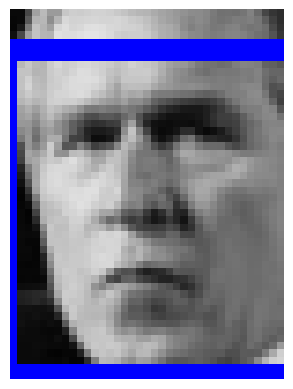

In [17]:
faces = detect_faces(example_image)
print(f"Example Image: Faces detected: {faces}")
visualize_detected_faces(example_image, faces)

Extract and match features for each detected face

In [19]:
for i, bbox in enumerate(faces):
    face_embedding = extract_embeddings(example_image, bbox)
    face_embedding = face_embedding.reshape(1, -1)
    predicted_label = knn.predict(face_embedding)
    predicted_name = target_names[predicted_label[0]]
    print(f"Face {i}: Predicted label: {predicted_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Face 0: Predicted label: George W Bush


Test face detection on a different image (non-LFW)

In [21]:
different_image_path = 'example.jpg'
different_image = cv2.imread(different_image_path, cv2.IMREAD_GRAYSCALE)
if different_image is not None:
    faces = detect_faces(different_image)
    print(f"Non-LFW Image: Faces detected: {faces}")
    visualize_detected_faces(different_image, faces)
else: print("Non-LFW image not found.")

Non-LFW image not found.
